In [ ]:
#rename part

import os

folder_path = 'your_path'  

crop_count = 1
weed_count = 1

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # Read the first line of the txt file
        label = None
        with open(os.path.join(folder_path, filename), 'r') as file:
            first_line = file.readline().strip()
            label = first_line.split()[0]

        if label == '0':
            new_name = f'crop_{crop_count}'
            crop_count += 1
        elif label == '1':
            new_name = f'weed_{weed_count}'
            weed_count += 1

       # Find the corresponding image file
        image_file = filename.replace('.txt', '.jpeg') 
        image_path = os.path.join(folder_path, image_file)

        # Check if the target file name already exists to avoid renaming conflicts
        new_image_name = f'{new_name}.jpeg'
        new_image_path = os.path.join(folder_path, new_image_name)
        
        if os.path.exists(new_image_path):
            print(f"File {new_image_name} already exists, skipping renaming.")
        else:
            # If it does not exist, rename the image file
            if os.path.exists(image_path):
                os.rename(image_path, new_image_path)
        
        new_txt_name = f'{new_name}.txt'
        new_txt_path = os.path.join(folder_path, new_txt_name)

        if os.path.exists(new_txt_path):
            print(f"File {new_txt_name} already exists, skipping renaming.")
        else:
            # rename files
            os.rename(os.path.join(folder_path, filename), new_txt_path)

print("File renaming completed")

File renaming completed


In [ ]:
# batch detection

import cv2
import numpy as np
import os

# Global variables
net = None
LABELS = []
COLORS = []
total_images = 0
correct_predictions = 0

# Load YOLO model function
def load_yolo_model():
    global net, LABELS, COLORS
    labelsPath = '../data/names/obj.names'
    LABELS = open(labelsPath).read().strip().split("\n")
    weightsPath = '../data/weights/crop_weed_detection.weights'
    configPath = '../data/cfg/crop_weed.cfg'
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    print("[INFO] YOLO model loaded from disk...")
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# Batch detection function with confidence saving
def batch_test_images(folder_path):
    global total_images, correct_predictions
    total_images = 0
    correct_predictions = 0

    # Traverse all the pictures in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".jpeg", ".png", ".gif")):
            true_label = "crop" if "crop" in filename.lower() else "weed"
            image_path = os.path.join(folder_path, filename)
            print(f"[INFO] Processing {filename}...")

            # Read and detect images
            image = cv2.imread(image_path)
            if image is None:
                print(f"[WARNING] Could not read {filename}. Skipping.")
                continue

            detected_label, confidence = detect_and_classify_image(image)
            
            # Compare the detection results with the true labels
            if detected_label == true_label:
                correct_predictions += 1
            total_images += 1
            
            # Save the test result image with confidence
            save_detected_image(image, filename, detected_label, confidence)

    # Output matching results
    if total_images > 0:
        accuracy = (correct_predictions / total_images) * 100
        print(f"[RESULT] Total Images: {total_images}")
        print(f"[RESULT] Correct Predictions: {correct_predictions}")
        print(f"[RESULT] Accuracy: {accuracy:.2f}%")
    else:
        print("[RESULT] No valid images were processed.")

# Function to save detection results with confidence in filename
def save_detected_image(image, filename, detected_label, confidence):
    output_dir = "output_results"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{detected_label}_{confidence:.2f}_{filename}")
    cv2.imwrite(output_path, image)
    print(f"[INFO] Saved detected image with confidence {confidence:.2f} to {output_path}")

# Detection and classification function for individual images
def detect_and_classify_image(image):
    global net, LABELS, COLORS
    (H, W) = image.shape[:2]
    confi = 0.5
    thresh = 0.5

    ln = net.getLayerNames()
    unconnected_out_layers = net.getUnconnectedOutLayers()
    if len(unconnected_out_layers) > 0:
        ln = [ln[i - 1] for i in unconnected_out_layers.flatten()]
    
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (512, 512), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > confi:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    if len(classIDs) > 0:
        main_class_id = max(set(classIDs), key=classIDs.count)
        detected_label = LABELS[main_class_id]
        confidence = max(confidences)
    else:
        detected_label = "unknown"
        confidence = 0.0

    return detected_label, confidence

# Main code execution
if __name__ == "__main__":
    # Load YOLO model
    load_yolo_model()

    # Get folder path from user
    folder_path = 'your_path'

    # Check if folder exists
    if os.path.isdir(folder_path):
        batch_test_images(folder_path)
    else:
        print("[ERROR] The specified folder path does not exist.")


[INFO] YOLO model loaded from disk...
[INFO] Processing crop_1.jpeg...
[INFO] Saved detected image with confidence 0.97 to output_results\crop_0.97_crop_1.jpeg
[INFO] Processing crop_10.jpeg...
[INFO] Saved detected image with confidence 0.96 to output_results\crop_0.96_crop_10.jpeg
[INFO] Processing crop_100.jpeg...
[INFO] Saved detected image with confidence 0.00 to output_results\unknown_0.00_crop_100.jpeg
[INFO] Processing crop_101.jpeg...
[INFO] Saved detected image with confidence 0.99 to output_results\crop_0.99_crop_101.jpeg
[INFO] Processing crop_102.jpeg...
[INFO] Saved detected image with confidence 0.87 to output_results\crop_0.87_crop_102.jpeg
[INFO] Processing crop_103.jpeg...
[INFO] Saved detected image with confidence 0.98 to output_results\crop_0.98_crop_103.jpeg
[INFO] Processing crop_104.jpeg...
[INFO] Saved detected image with confidence 0.00 to output_results\unknown_0.00_crop_104.jpeg
[INFO] Processing crop_105.jpeg...
[INFO] Saved detected image with confidence 0

KeyboardInterrupt: 

File name statistics results：
crop_crop: 562
crop_weed: 8
unknown_crop: 55
unknown_weed: 52
weed_weed: 606
weed_crop: 17

total_predictions：1300
correct_predictions：1168
accuracy：89.85%


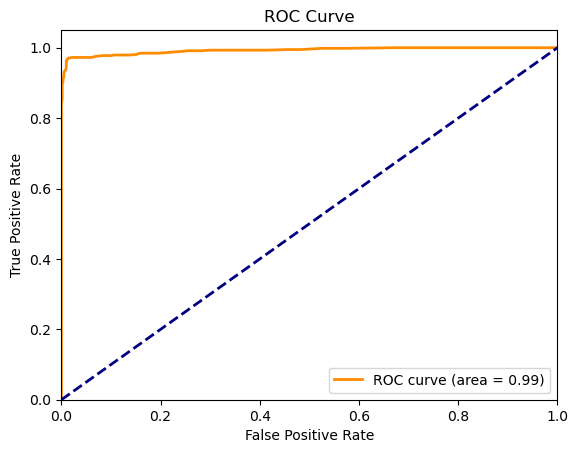

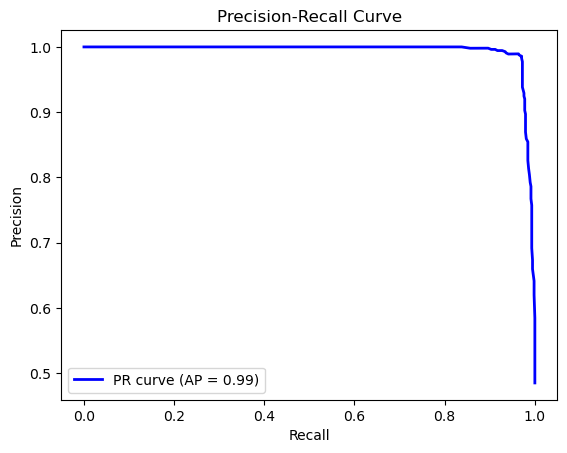

In [ ]:
#statistic part

import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

folder_path = 'your_path'

# Count predication accuracy
result_counts = Counter()

# A list used to save prediction results, confidence rates, and standard results
y_true = []
y_scores = []

# Iterate through the files in a folder
for filename in os.listdir(folder_path):
    # Check if the file name format complies with 'a_0.54_b_1.jpeg'
    if filename.count('_') == 3 and filename.endswith('.jpeg'):
        match = re.match(r"(.*)_(\d+\.\d+)_(.*)_(\d+)\.jpeg", filename)
        if match:
            predicted_label = match.group(1)  # Predicted Label
            confidence = float(match.group(2))  # Confidence
            actual_label = match.group(3)  # standard label
            
            # Update statistics results
            result_counts[f"{predicted_label}_{actual_label}"] += 1
            
            # Skip unknown prediction results
            if predicted_label == "unknown":
                continue

            # Convert the standard labels to binary format, crop is 1, weed is 0
            y_true.append(1 if actual_label == "crop" else 0)
            y_scores.append(confidence if predicted_label == "crop" else 1 - confidence)

# Output statistical results
print("File name statistics results：")
for key, count in result_counts.items():
    print(f"{key}: {count}")

# Calculate accuracy
correct_predictions = result_counts['crop_crop'] + result_counts['weed_weed']
total_predictions = sum(result_counts.values())
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

print(f"\ntotal_predictions：{total_predictions}")
print(f"correct_predictions：{correct_predictions}")
print(f"accuracy：{accuracy * 100:.2f}%")

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plotting the PR curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
